In [1]:
#news stuff
import newspaper
from newsapi import NewsApiClient

#utilities
from datetime import date
import pandas as pd
import numpy as np

#cluster stuff
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.neighbors import NearestNeighbors

#nlp stuff
import spacy
nlp = spacy.load('en_core_web_lg')

#summarization
from rake_nltk import Rake
rake_nltk_var = Rake()

In [2]:
api_key = '5964b2e875064a83a9033afc11f48101'
newsapi = NewsApiClient(api_key=api_key)

In [3]:
def get_trending_articles_today(num_trends):
    today = date.today().strftime("%Y-%m-%d")

    trending_topics = newspaper.hot()
    if num_trends < len(trending_topics):
        trending_topics = trending_topics[:num_trends]

    data = []
    for topic in trending_topics:
        articles = []
        for i in range(1, 5):
            page_articles = newsapi.get_everything(q=topic,
                                      language='en',
                                      from_param=today,
                                      page=i)

            if len(page_articles) == 0:
                break
            else:
                articles.extend(page_articles["articles"])

        # add article info
        article_info = [(article['publishedAt'], article['title'], article['url'], topic) for article in articles]
        data.extend(article_info)
    
    return pd.DataFrame(data, columns=["date", "title", "url", "topic"])

In [4]:
def preprocess_text(text):
    doc = nlp(text)
    tokens = [w.lower_ for w in doc if not (w.is_stop or w.is_punct)]
    preproc_text = " ".join(tokens) 
    return preproc_text 

In [26]:
def get_best_eps_val(vectors, neighbors=2):
    neigh = NearestNeighbors(n_neighbors=neighbors)
    nbrs = neigh.fit(vectors)

    distances, indices = nbrs.kneighbors(vectors)

    # return half of first non zero distance value
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    non_zero = distances.nonzero()

    return distances[non_zero[0][0]] / 2, distances

In [35]:
def get_best_min_sample_val(num_total_articles, factor=132):
    return int(num_total_articles / factor)


def cluster_articles(df):
    sent_vecs = {}
    # make each article title into a vector
    for title in df.title:
        try:
            doc = nlp(preprocess_text(title))
            sent_vecs.update({title: doc.vector})
        except Exception as e:
            print(e)

    vectors = list(sent_vecs.values())
    x = np.array(vectors)

    # finds best hyper parameters for dbscan
    eps, distances = get_best_eps_val(x)
    print(eps)
    min_articles = get_best_min_sample_val(len(df))
    # clusters articles using dbscan
    dbscan = DBSCAN(eps=.25, min_samples=min_articles, metric='cosine').fit(x)

    titles = list(sent_vecs.keys())
    return pd.DataFrame({'label': dbscan.labels_, 'title': titles, 'vectors': vectors}), distances

In [7]:
def get_mean_vec(vectors):
    total = np.zeros(300)
    for vec in vectors:
        total += vec

    mean = total / len(vectors)
    return mean


In [8]:
def get_central_vec_title(cluster):
    vectors = cluster.vectors.to_list()

    mean_vec = get_mean_vec(vectors)
    index = pairwise_distances_argmin_min(np.array([mean_vec]), vectors)[0][0]
    
    return cluster.title.iloc[index]

In [9]:
def get_categorized_news(clusters, article_df):
    summarized_news = []
    for cluster in clusters.label.unique():
        #unclustered category
        if cluster == -1:
            continue
        
        # get best article from cluster
        cluster_titles = clusters.loc[clusters.label == cluster]
        best_article = get_central_vec_title(cluster_titles)

        #look up in original df
        cluster_df = article_df.loc[article_df.title == best_article].copy()
        cluster_df["num_articles"] = len(cluster_titles)

        summarized_news.append(cluster_df)

    return pd.concat(summarized_news)

In [11]:
trending_news = get_trending_articles_today(100)
trending_news = trending_news.drop_duplicates(subset=['title'])

In [77]:
# put all trending news into clusters and pick most objective article for each one
clusters, distances = cluster_articles(trending_news)
summarized_news = get_categorized_news(clusters, trending_news)

# summarize each cluster
summarized_news = summarized_news.reset_index(drop=True)

1.1821269451114038e-07


In [31]:
import matplotlib.pyplot as plt

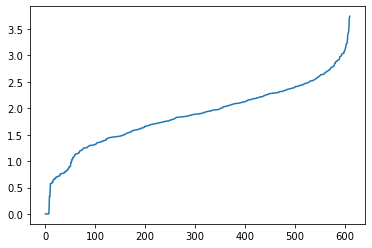

In [32]:
plt.plot(distances)

In [79]:
summarized_news

,date,title,url,topic,num_articles
0,2021-08-11T10:32:39Z,"'Hard Knocks' Power Rankings: Dak Prescott, Mi...",https://slashdot.org/firehose.pl?op=view&amp;i...,Hard Knocks 2021,47
1,2021-08-11T17:10:18Z,NFL playoff teams that could miss postseason i...,https://www.cbssports.com/nfl/news/nfl-playoff...,Hard Knocks 2021,4
2,2021-08-11T13:01:06Z,Chris Cuomo Defied CNN Ban On Advising His Sex...,http://www.womensystems.com/2021/08/chris-cuom...,Kerry Kennedy,271
3,2021-08-11T09:46:30Z,Messi joins PSG: Lionel Messi talks about play...,https://www.insidesport.co/messi-joins-psg-lio...,PSG,83
4,2021-08-11T04:34:17Z,Christina Applegate announces multiple scleros...,https://www.scotsman.com/health/christina-appl...,Christina Applegate,4
5,2021-08-11T01:59:33Z,Idris Elba joins ‘Sonic the Hedgehog 2’ as voi...,https://www.foxnews.com/entertainment/idris-el...,Idris Elba,16
6,2021-08-11T15:09:56Z,'This is a mistake': Steve Bannon slams Mike L...,https://www.rawstory.com/steve-bannon-mike-lin...,Mike Lindell,7
7,2021-08-11T01:37:57Z,OANN and Newsmax sued by Dominion over voting ...,https://www.nydailynews.com/news/national/ny-o...,Mike Lindell,5
8,2021-08-11T00:30:52Z,Exterran Corp (EXTN) Q2 2021 Earnings Call Tra...,https://www.fool.com/earnings/call-transcripts...,Infrastructure bill 2021,9


In [38]:
trending_news.topic.value_counts()

PSG                            80
Andrew Cuomo                   79
Infrastructure bill 2021       76
Jennifer Aniston               69
Tropical Storm Fred            58
Mike Lindell                   41
Phillies                       33
Idris Elba                     30
Hard Knocks 2021               24
Dennis Schroder                23
Kylie Jenner                   21
Kissing Booth 3                19
Cameron Burrell                12
Tony Esposito                  12
Excessive heat warning         10
Christina Applegate            10
Kerry Kennedy                   7
Severe thunderstorm warning     6
Vicente Fernandez               1
Name: topic, dtype: int64